In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf

In [15]:
class MovingAverageRSIStrategy:
    def __init__(self,capital,stock,start,end,short_peroid,long_peroid):
        self.capital = capital
        self.stock = stock
        self.start = start
        self.end = end
        self.short_peroid = short_peroid
        self.long_peroid = long_peroid
        self.equity = [capital]
        self.is_long = False
        self.data = None
    
    def download_data(self):
        stock_data={}
        ticker = yf.download(self.stock,self.start,self.end)
        stock_data['price'] = ticker['Adj Close']
        self.data = pd.DataFrame(stock_data)
        
    def construct_signals(self):
        self.data['short_ma'] = self.data['price'].ewm(span=self.short_peroid).mean()
        self.data['long_ma'] = self.data['price'].ewm(span=self.long_peroid).mean()
        self.data['move'] = self.data['price'] - self.data['price'].shift(1)
        self.data['up'] = np.where(self.data['move'] > 0, self.data['move'],0)
        self.data['down'] = np.where(self.data['move'] < 0,self.data['move'],0 )
        self.data['average_gain'] = self.data['up'].abs().rolling(window=14).mean()
        self.data['average_loss'] = self.data['down'].abs().rolling(window=14).mean()
        RS = self.data['average_gain'] / self.data['average_loss']
        self.data['RSI'] = 100 - (100 / (1.0 + RS))
        self.data = self.data.dropna()
        
    def simulate(self):
        price_when_bought = 0
        
        for index,row in self.data.iterrows():
            if row['short_ma'] < row['long_ma'] and self.is_long:
                self.equity.append(row['price']*self.capital / price_when_bought)
                self.is_long = False
            elif row['short_ma'] > row['long_ma'] and not self.is_long and row['RSI'] < 30:
                price_when_bought = row['price']
                self.is_long = True
                
    def plot_signals(self):
        plt.figure(figsize=(16,8))
        plt.plot(self.data['price'],label='stock price')
        plt.plot(self.data['short_ma'],label='short ma')
        plt.plot(self.data['long_ma'],label='long ma')
        plt.title('Moving average Crossover Trading Strategy with RSI')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.show()
        
    def plot_equity(self):
        print('Profit of the trading strategy: %.2f%%' % ((float(self.equity[-1])- float(self.equity[0]))/float(self.equity[0])*100))
        print('Actual capital: %0.2f%%' % self.equity[-1])
        plt.figure(figsize=(16,6))
        plt.title('Equity Curve')
        plt.plot(self.equity,label='stock price',color='green')
        plt.xlabel('Date')
        plt.ylabel('Actual Capital')
        plt.show()
        

In [16]:
start_date = datetime.datetime(2015,1,1)
end_date = datetime.datetime(2020,1,1)
model = MovingAverageRSIStrategy(100,'IBM',start_date,end_date,30,100)

[*********************100%***********************]  1 of 1 completed


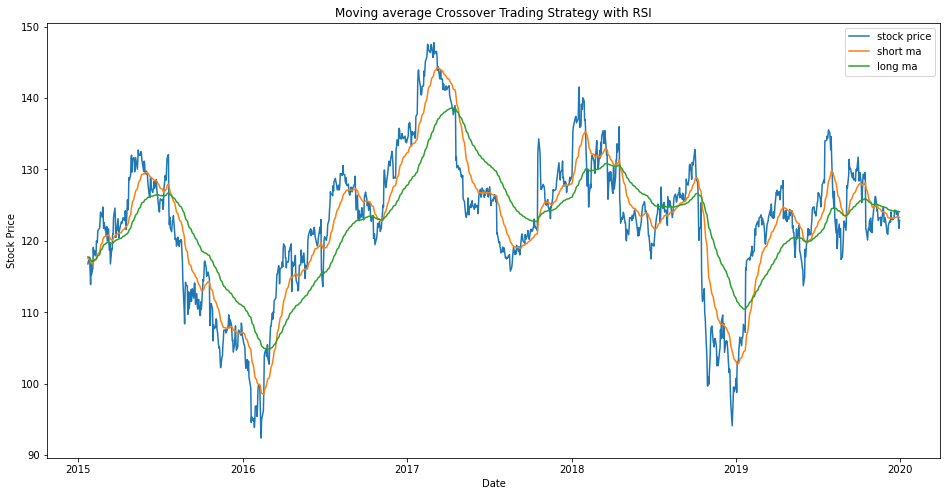

Profit of the trading strategy: -0.20%
Actual capital: 99.80%


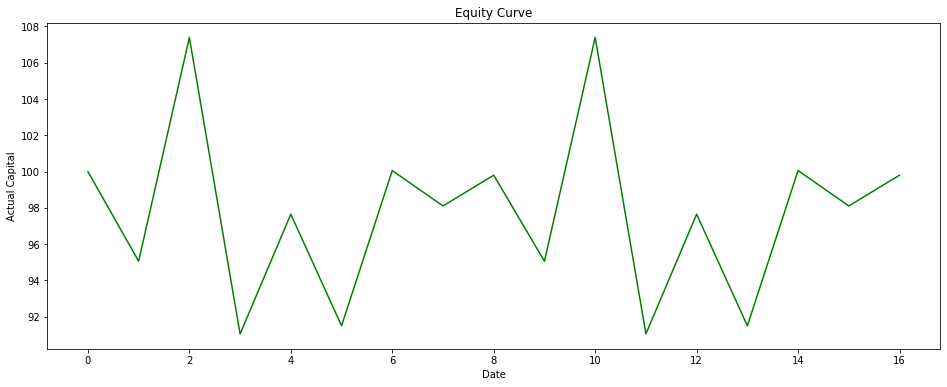

In [18]:
model.download_data()
model.construct_signals()
model.plot_signals()
model.simulate()
model.plot_equity()